In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Parameters for data generation
sh = int(1e4)  # Number of samples

# Define low and high bounds for each dimension
lows = [0, 0, 1.0, 10, 0.1]  # [t, phi0, omega0, Mc, eta]
highs = [10, 2 * np.pi, 10.0, 80, 0.25]

# Sample uniformly from the 5D space
samples = np.random.uniform(low=lows, high=highs, size=(sh, 5))
results = np.zeros((sh, 2))  # To store [omega(t), phi(t)]

# Define the true system
def true_system(t, y, Mc, eta):
    omega, phi = y
    d_omega = -eta * omega + (1 / Mc) * np.sin(phi)
    d_phi = omega
    return [d_omega, d_phi]
def true_system_torch(omega, phi, Mc, eta):
    d_omega = -eta * omega + (1 / Mc) * torch.sin(phi)
    d_phi = omega
    return d_omega, d_phi

In [2]:
data_tensor = torch.load("./data_test.pt")  # Shape: (N, 7)

In [3]:
X_data = data_tensor[:, :5]
Y_data = data_tensor[:, 5:]

In [4]:
# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# ========== Train-test Split ==========
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)
X_tensor = X_train.clone().detach().to(torch.float32).to(device)
Y_tensor = y_train.clone().detach().to(torch.float32).to(device)
X_val_tensor = X_test.clone().detach().to(torch.float32).to(device)
Y_val_tensor = y_test.clone().detach().to(torch.float32).to(device)


train_loader = DataLoader(TensorDataset(X_tensor, Y_tensor), batch_size=256, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=512)

In [6]:
class PINN(nn.Module):
    def __init__(self, physics_func, input_size=5, hidden_size=64, output_size=2, num_hidden=4):
        super(PINN, self).__init__()
        self.physics_func = physics_func
        layers = [nn.Linear(input_size, hidden_size), nn.Tanh()]
        for _ in range(num_hidden - 1):
            layers += [nn.Linear(hidden_size, hidden_size), nn.Tanh()]
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def physics_loss(self, x):
        x = x.clone().detach().requires_grad_(True)  # Ensure x is differentiable
        y_pred = self.forward(x)

        omg_pred = y_pred[:, 0:1]
        phi_pred = y_pred[:, 1:2]

        # Use autograd w.r.t. full x, then slice ∂/∂t from column 0
        grads_omega = torch.autograd.grad(
            outputs=omg_pred,
            inputs=x,
            grad_outputs=torch.ones_like(omg_pred),
            create_graph=True
        )[0]
        d_omg_dt = grads_omega[:, 0:1]  # ∂ω/∂t

        grads_phi = torch.autograd.grad(
            outputs=phi_pred,
            inputs=x,
            grad_outputs=torch.ones_like(phi_pred),
            create_graph=True
        )[0]
        d_phi_dt = grads_phi[:, 0:1]  # ∂φ/∂t

        # Extract parameters from input
        Mc = x[:, 3:4]
        eta = x[:, 4:5]

        # Ground-truth derivatives from the true system
        d_omg_true, d_phi_true = self.physics_func(omg_pred, phi_pred, Mc, eta)

        loss_omg = nn.MSELoss()(d_omg_dt, d_omg_true)
        loss_phi = nn.MSELoss()(d_phi_dt, d_phi_true)

        return loss_omg, loss_phi


In [7]:
# ========== Instantiate Model, Optimizer ==========
model = PINN(physics_func=true_system_torch).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # Decay LR by 0.1 every 20 epochs
criterion = nn.MSELoss()

Epoch 1/150, Train Loss: 236.606383, Val Loss: 183.785763, ω Loss: 24.235284, φ Loss: 1.808213, IC Loss: 16.183829


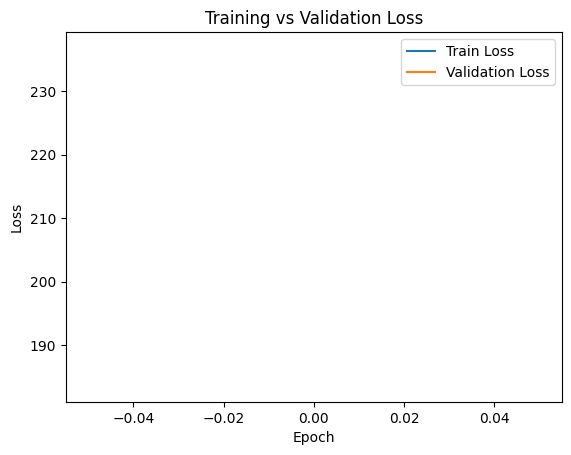

Epoch 16/150, Train Loss: 57.354572, Val Loss: 50.493576, ω Loss: 84.155699, φ Loss: 2.792235, IC Loss: 3.459020


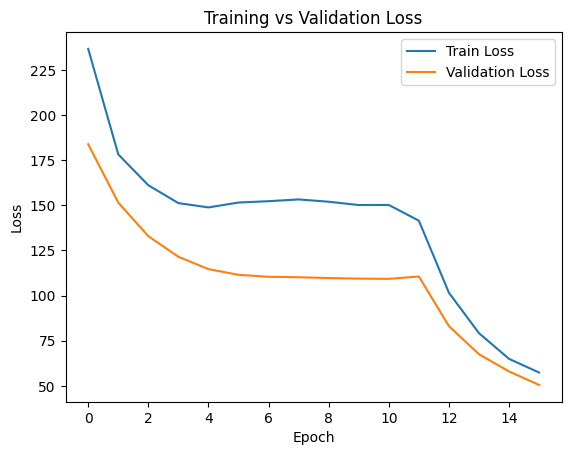

Epoch 31/150, Train Loss: 9.474328, Val Loss: 8.376779, ω Loss: 71.219028, φ Loss: 1.634322, IC Loss: 0.423716


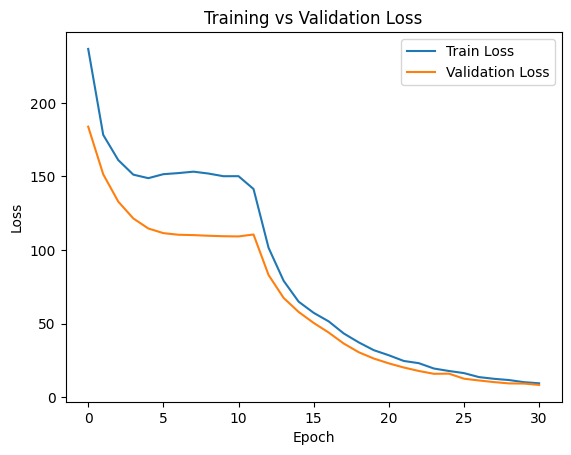

Epoch 46/150, Train Loss: 5.496849, Val Loss: 4.814464, ω Loss: 81.602138, φ Loss: 0.926612, IC Loss: 0.192388


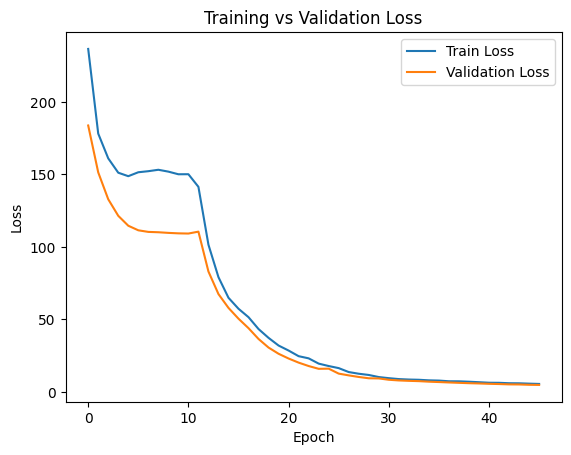

Epoch 61/150, Train Loss: 3.820293, Val Loss: 2.895469, ω Loss: 79.380029, φ Loss: 0.739092, IC Loss: 0.140545


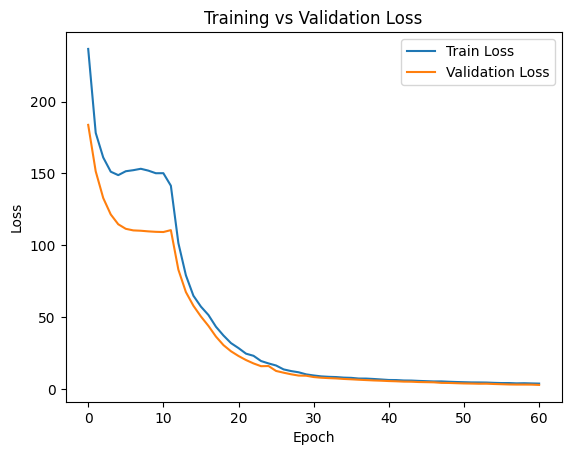

Epoch 76/150, Train Loss: 3.216377, Val Loss: 2.308409, ω Loss: 80.049046, φ Loss: 0.651830, IC Loss: 0.112843


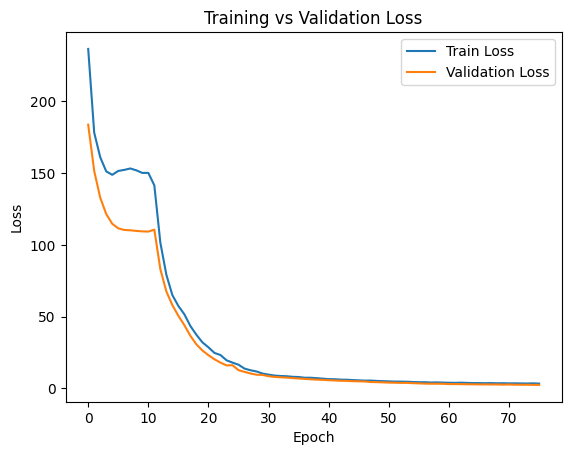

Epoch 91/150, Train Loss: 2.764357, Val Loss: 1.870497, ω Loss: 79.675613, φ Loss: 0.597190, IC Loss: 0.077729


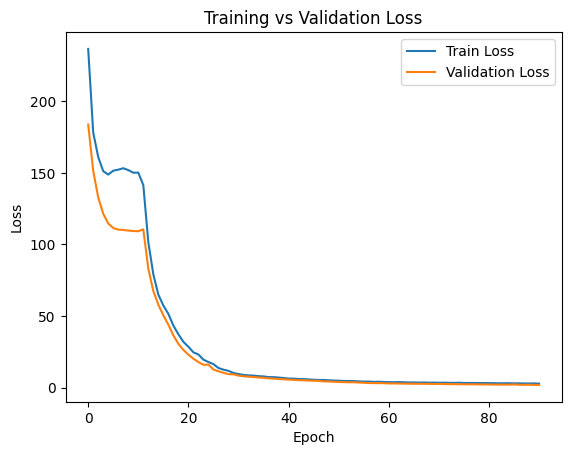

Epoch 106/150, Train Loss: 2.600649, Val Loss: 1.641685, ω Loss: 78.597084, φ Loss: 0.596141, IC Loss: 0.091506


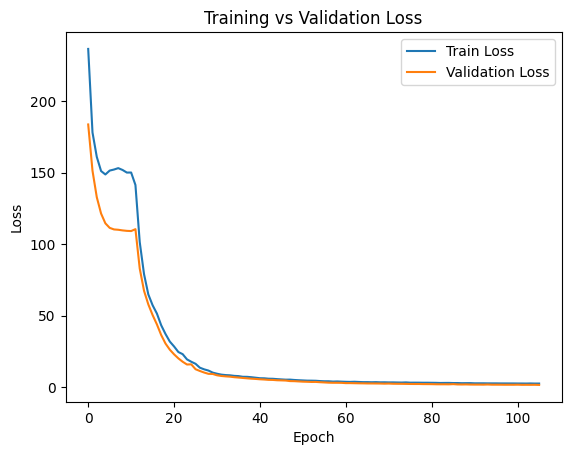

Epoch 121/150, Train Loss: 2.405757, Val Loss: 1.473804, ω Loss: 78.299495, φ Loss: 0.542469, IC Loss: 0.109520


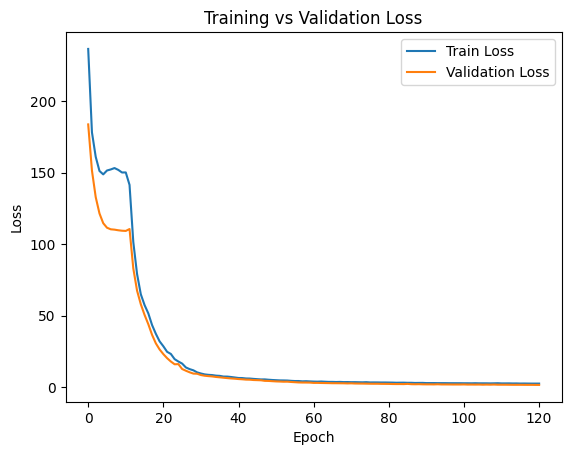

Epoch 136/150, Train Loss: 2.301270, Val Loss: 1.407301, ω Loss: 77.703739, φ Loss: 0.577094, IC Loss: 0.077210


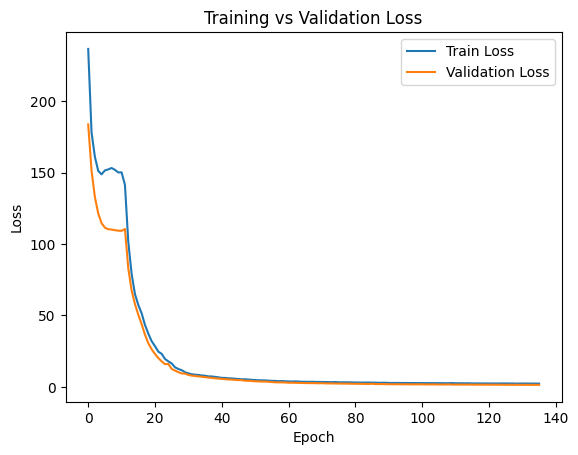

In [8]:
def weighted_ode_loss(ode_loss_omega, ode_loss_phi, weight_omega=1.0, weight_phi=1.0):
    return weight_omega * ode_loss_omega + weight_phi * ode_loss_phi

# Set your desired weights
omega_weight = 0.1
phi_weight = 1
ic_loss_weight = 1
physics_loss_weight = 0.1

# Define optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
criterion = nn.MSELoss()

# Prepare DataLoaders
train_loader = DataLoader(TensorDataset(X_tensor, Y_tensor), batch_size=256, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, Y_val_tensor), batch_size=512)

# Initialize lists
num_epochs = 150
train_losses, val_losses = [], []
omega_losses, phi_losses, ic_losses = [], [], []

plt.ion()
fig, ax = plt.subplots()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_omega_loss = 0
    total_phi_loss = 0
    total_ic_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        data_loss = criterion(pred, yb)

        ode_loss_omega, ode_loss_phi = model.physics_loss(xb)
        ode_loss = weighted_ode_loss(ode_loss_omega, ode_loss_phi, omega_weight, phi_weight)

        # Initial condition loss (based on min t in batch)
        t0_mask = xb[:, 0] == xb[:, 0].min()
        if t0_mask.any():
            pred_ic = pred[t0_mask]
            true_ic = yb[t0_mask]
            ic_loss = criterion(pred_ic, true_ic)
        else:
            ic_loss = torch.tensor(0.0, device=device)

        loss = data_loss + physics_loss_weight * ode_loss + ic_loss_weight * ic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_omega_loss += ode_loss_omega.item()
        total_phi_loss += ode_loss_phi.item()
        total_ic_loss += ic_loss.item()

    scheduler.step()

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)
    omega_losses.append(total_omega_loss / len(train_loader))
    phi_losses.append(total_phi_loss / len(train_loader))
    avg_ic_loss = total_ic_loss / len(train_loader)
    ic_losses.append(avg_ic_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            val_loss += criterion(pred, yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    if epoch % 15 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.6f}, "
          f"Val Loss: {val_loss:.6f}, "
          f"ω Loss: {omega_losses[-1]:.6f}, "
          f"φ Loss: {phi_losses[-1]:.6f}, "
          f"IC Loss: {avg_ic_loss:.6f}")

        # Live plot
        plt.clf()
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training vs Validation Loss')
        plt.legend()
        plt.pause(0.1)

plt.show()

In [9]:
def predict_physical(X_input, model, device):
    """
    Predict physical omega and phi from input [t, phi0, omg0, Mc, eta] (unscaled).

    Parameters:
    - X_input: numpy array or torch tensor of shape [N, 5]
    - model: trained PyTorch model
    - device: torch device (e.g. 'cuda' or 'cpu')

    Returns:
    - omega_pred: predicted omega values (physical units)
    - phi_pred: predicted phi values (physical units)
    """
    # Convert to tensor if needed
    if isinstance(X_input, np.ndarray):
        X_tensor = torch.from_numpy(X_input).to(torch.float32).to(device)
    elif isinstance(X_input, torch.Tensor):
        X_tensor = X_input.clone().detach().to(torch.float32).to(device)
    else:
        raise TypeError("X_input must be a NumPy array or PyTorch tensor")

    # Model prediction
    model.eval()
    with torch.no_grad():
        y_pred = model(X_tensor)

    omega_pred = y_pred[:, 0].cpu().numpy()
    phi_pred = y_pred[:, 1].cpu().numpy()

    return omega_pred, phi_pred


In [12]:
(t,phi0, omg0, Mc, eta)=(3.7,np.pi/3,4.3,25,0.2)
X_in=np.array([t, Mc, eta,omg0,phi0]).reshape(1, -1)

In [13]:
def get_PHI_omg(t0, phi0, omg0, Mc, eta, t_epoch):
    sol = solve_ivp(
        true_system,
        [t0, t_epoch],
        y0=[omg0, phi0],
        args=(Mc, eta),
        t_eval=[t_epoch],
        rtol=1e-9,
        atol=1e-9
    )
    return sol.y[1, 0], sol.y[0, 0]  # phi(t), omega(t)

In [14]:
get_PHI_omg(0, phi0, omg0, Mc, eta, t)

(np.float64(12.300380357458984), np.float64(2.0346050502223667))

In [17]:
predict_physical(X_in, model,device)

(array([2.036558], dtype=float32), array([12.2400255], dtype=float32))